# Concordance between FarGen and gnomAD

**NOTE:** Maybe *concordance* isn't the correct word, as it usually refers to genotype concordance. Maybe *overlap* is more suitable.

# Concordance between FarGen and gnomAD

**NOTE:** Maybe *concordance* isn't the correct word, as it usually refers to genotype concordance. Maybe *overlap* is more suitable.

In [4]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '10g', 'spark.local.dir': '/home/olavur/tmp'})

Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-7889d4ff4c-6wxtc:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/gnomad_exome_sites/hail-20210316-1045-0.2.61-3c86d3ba497a.log


In [5]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

In [6]:
import pandas as pd
import numpy as np

In [7]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'

## Load gnomAD exome sites data

In [8]:
gnomad_ht = hl.read_table(BASE_DIR + '/data/resources/gnomAD/gnomad.exomes.r2.1.1.sites.GRCh38.ht')

In [9]:
n_variants = gnomad_ht.count()
print('Number of variants: ' + str(n_variants))

Number of variants: 17204631


## Load FarGen data annotated with gnomAD data

In [10]:
fargen_mt = hl.read_matrix_table(BASE_DIR + '/data/mt/hq_gnomad_annotated.mt')

## Concordance

We want to compare the rows in the two datasets, so we take out the rows of the FarGen matrix table, and remove all unnecessary fields from both datasets.

In [11]:
fargen_sites_ht = fargen_mt.rows()
fargen_sites_ht = fargen_sites_ht.select()

In [12]:
gnomad_sites_ht = gnomad_ht.select()

Count the number of sites in each dataset.

In [13]:
n_fargen_sites = fargen_sites_ht.count()
n_gnomad_sites = gnomad_sites_ht.count()

Count the number of sites present in *both* datasets, the *intersection*.

In [14]:
intersection_ht = fargen_sites_ht.semi_join(gnomad_sites_ht)
n_intersection = intersection_ht.count()

Count the sites in the union.

**NOTE:** There is a `union()` method, but the resulting rows are duplicated.

In [15]:
# Number of sites in union equal to sum of sites in each dataset, minus the intersection.
n_union = n_fargen_sites + n_gnomad_sites - n_intersection

Calculate the differences, i.e. the sites present in FarGen but *not* gnomAD, and vice versa.

In [16]:
fargen_no_gnomad_ht = fargen_sites_ht.anti_join(gnomad_sites_ht)
n_fargen_no_gnomad = fargen_no_gnomad_ht.count()

In [17]:
gnomad_no_fargen_ht = gnomad_sites_ht.anti_join(fargen_sites_ht)
n_gnomad_no_fargen = gnomad_no_fargen_ht.count()

In [18]:
count_list = [n_fargen_sites, n_gnomad_sites, n_union, n_intersection, n_fargen_no_gnomad, n_gnomad_no_fargen]
index = ['FarGen', 'gnomAD', 'Union', 'Intersection', 'FarGen\gnomAD', 'gnomAD\FarGen']
pd.DataFrame(count_list, index=index, columns=['Variant count'])

,Variant count
FarGen,1194405
gnomAD,17204631
Union,18203545
Intersection,195491
FarGen\gnomAD,998914
gnomAD\FarGen,17009100


In [19]:
assert n_fargen_sites - n_fargen_no_gnomad == n_intersection
assert n_union - n_fargen_no_gnomad == n_gnomad_sites

In [20]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt

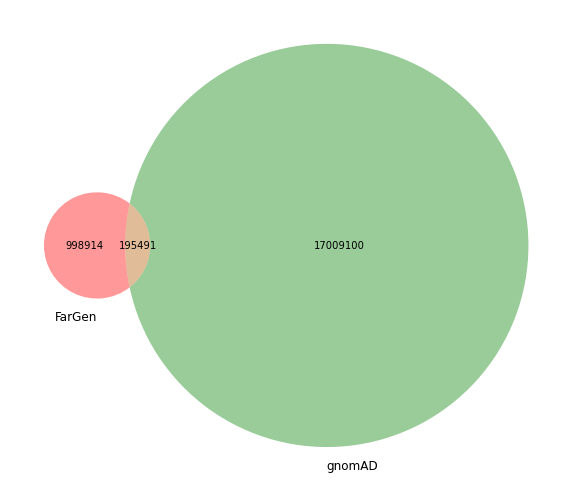

In [21]:
%matplotlib inline
plt.figure(figsize=(10, 10))
p = venn2(subsets = (n_fargen_no_gnomad, n_gnomad_no_fargen, n_intersection), set_labels = ('FarGen', 'gnomAD'))